# BOSTON HOUSING : Linear Regression¶

## Dataset Description:

###### crim : per capita crime rate by town
##### zn : proportion of residential land zoned for lots over 25,000 sq.ft.
##### indus : proportion of non-retail business acres per town.
##### chas : Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
##### nox : nitrogen oxides concentration (parts per 10 million).
##### rm : average number of rooms per dwelling.
##### age : proportion of owner-occupied units built prior to 1940.
##### dis : weighted mean of distances to five Boston employment centres.
##### rad : index of accessibility to radial highways.
##### tax : full-value property-tax rate per  ten thousand
##### ptratio : pupil-teacher ratio by town.
##### black : 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
##### lstat : lower status of the population (percent).
##### mdev : median value of owner-occupied homes in thousand (target variable)

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import datetime
import math


In [4]:
boston = load_boston()
boston_dataset = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_dataset['MEDV'] =  boston.target

In [5]:
boston_dataset.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Feature Selection

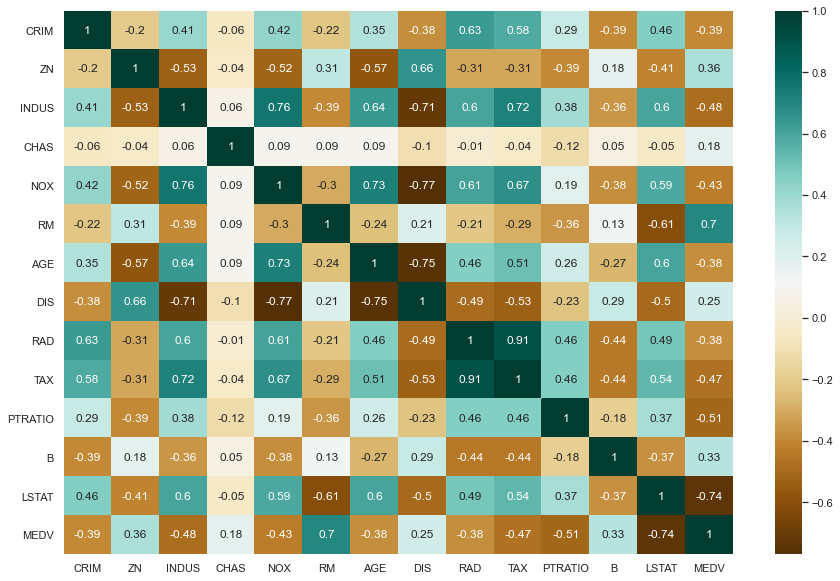

In [6]:
corr_matrix = boston_dataset.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True, cmap="BrBG")
plt.show()

In [7]:
relevant_features = abs(corr_matrix["MEDV"])
relevant_features = relevant_features[relevant_features > 0.5]
#relevant_features are featiures that are highly correlated with target variable

In [8]:
relevant_features
#This implies RM,PTRATIO and LSTAT are highly correlated with MEDV
#also RM and LSTAT are highly correlated so we choose LSTAT because it is more
#correlated with target MEDV

RM         0.70
PTRATIO    0.51
LSTAT      0.74
MEDV       1.00
Name: MEDV, dtype: float64

In [9]:
boston_dataset[["RM", "PTRATIO", "LSTAT"]].corr().round(2)


,RM,PTRATIO,LSTAT
RM,1.00,-0.36,-0.61
PTRATIO,-0.36,1.00,0.37
LSTAT,-0.61,0.37,1.00


In [10]:

X = boston_dataset[['PTRATIO', 'LSTAT']]
y = boston_dataset.MEDV

## Data Preprocessing

In [11]:
def split_data(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""
    
    # set seed to have reproducible/consistent results
    np.random.seed(seed)
    
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    
    # create split
    x_tr = x.iloc[index_tr]
    x_te = x.iloc[index_te]
    y_tr = y.iloc[index_tr]
    y_te = y.iloc[index_te]
    return x_tr, x_te, y_tr, y_te

def standardize(x):
    """Standardize the original data set."""
    return (x - x.mean(axis=0))/ x.std(axis=0)

def build_model_data(x):
    """Form tX to get regression data in matrix form. tX is X with intercept"""
    num_samples = y.shape[0]
    x["INTERCEPT"] = pd.Series(np.ones(num_samples))
    return x

def prepare_model(X, y, r, s) :
    """Apply all previous helper functions to preprocess data"""
    
    X_train, X_test, y_train, y_test = split_data(X, y, r, seed=s)
    
    X_train = standardize(X_train)
    X_train = build_model_data(X_train)
    
    X_test = standardize(X_test)
    X_test = build_model_data(X_test)
    
    return X_train, X_test, y_train, y_test



In [16]:
X_train, X_test, y_train, y_test = prepare_model(X, y, 0.9, 1)


# Implementation

In [17]:
def mse(e):
    """Compute the mse for the error vector e."""
    return 1/2*np.mean(e**2)

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

In [18]:
def gradient_descent(y, tx, initial_w, max_iters, gamma, epsilon = 10e-5):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    prev = math.inf
    for n_iter in range(max_iters):
        # compute loss, gradient and rmse(actual loss)
        grad, err = compute_gradient(y, tx, w) 
        loss = np.sqrt(2 * mse(err))
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        #Stop earlier if we reached convergence
        if(abs(loss - prev) < epsilon) :
            print("Reached Convergence !")
            break
        prev = loss
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}, w2={w2}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1], w2=w[2]))

    return losses, ws

In [21]:
max_iters = 1000
#total number of iterations = 1000
gamma = 0.7
# learning rate value = 0.7
# Initialization
w_initial = np.array([0, 0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y_train, X_train, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

#Get final weights
params = gradient_ws[-1]

#Model is y = w2 + w0*PTRATIO + w1*LSTAT
pred = params[2] + params[0]*X_test.PTRATIO + params[1]*X_test.LSTAT


Gradient Descent(0/999): loss=24.614369072457755, w0=-3.2729074300943077, w1=-4.805168507903803, w2=15.94492307692308
Gradient Descent(1/999): loss=9.087882735556304, w0=-3.0051969192237102, w1=-5.39956334055006, w2=20.728400000000036
Gradient Descent(2/999): loss=6.259891262460133, w0=-2.769276837267815, w1=-5.648694816767846, w2=22.163443076923123
Gradient Descent(3/999): loss=5.924440708887853, w0=-2.6330902272978456, w1=-5.785415706856919, w2=22.59395600000005
Gradient Descent(4/999): loss=5.88826472895535, w0=-2.5563272296869877, w1=-5.862200311214201, w2=22.72310987692312
Gradient Descent(5/999): loss=5.883397595999119, w0=-2.513131957296604, w1=-5.905396457399949, w2=22.761856040000044
Gradient Descent(6/999): loss=5.882452610069755, w0=-2.488828511062295, w1=-5.929699938971293, w2=22.77347988892312
Gradient Descent(7/999): loss=5.8822071271486545, w0=-2.4751545064783596, w1=-5.943373944984288, w2=22.77696704360004
Reached Convergence !


In [23]:
#Performance evaluation
exection_time_np = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time_np))
train_loss_np = gradient_losses[-1]
print("Train loss : {}".format(train_loss_np))
test_loss_np = np.sqrt(2 * mse(y_test - pred))
print("Test loss : {}".format(test_loss_np))

Gradient Descent: execution time=0.161 seconds
Train loss : 5.882134247497131
Test loss : 5.146806236501715
